In [1]:
import os
import hf00
import random
from IPython.display import display, Audio
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

In [2]:
musan_dir = '../audioData/MUSAN/MUSAN/musan/'
speech_dir = os.listdir(musan_dir+'speech')
speech_files = []

for i in speech_dir:
    spech_dir = os.path.join((musan_dir+'speech'), i)
    if os.path.isdir(spech_dir):
        speech_files.extend(os.listdir(spech_dir))

In [6]:
#speech_files.sort()
speech_files.pop(0)

'LICENSE'

In [7]:
for i in range(0, len(speech_files)):
    folder = speech_files[i].split('-')
    #print(folder[1])
    if folder[1] == 'librivox':
        fname = musan_dir+'speech/librivox/'+speech_files[i]
        speech_files[i] = fname
    else:
        fname = musan_dir+'speech/us-gov/'+speech_files[i]
        speech_files[i] = fname

len(speech_files)


426

In [8]:
speech_files[0]

'../audioData/MUSAN/MUSAN/musan/speech/librivox/speech-librivox-0000.wav'

In [9]:
spectro_fn = T.Spectrogram(
    n_fft=256,
    hop_length=128,
    power=None)
inv_spectro_fn = T.InverseSpectrogram(
    n_fft=256,
    hop_length=128
)

In [10]:
class audioDataset(Dataset):

    def __init__(self, speech_list):
        #self.audio_df = pd.read_csv(audio_csvfile)
        self.speech_list = speech_list
        #self.audio_dir = audio_dir

    def __len__(self):
        return len(self.speech_list)
    
    def __getitem__(self, index):
    
        audio_path = self.speech_list[index]
        audio, label = hf00.get_random_audio_sec(audio_path)

        audio_spec = spectro_fn(audio)
        label_spec = spectro_fn(label)

        return audio_spec.real, label_spec.real

In [11]:
train_dataset = audioDataset(speech_files)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [12]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

class SpecAE(nn.Module):

    def __init__(self):
        super(SpecAE, self).__init__()
        
        self.enc = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1,padding=1),
            nn.LeakyReLU()
            )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=(2,3), stride=(2), padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=(2,2), stride=(2), padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size=(3), stride=(1), padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 256, kernel_size=(2,3), stride=(2), padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 512, kernel_size=(3,3), stride=(2), padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
    
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)

        return x

In [13]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

model = SpecAE()
#model.load_state_dict(torch.load('models/model00_conf03.pt'))
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
import statistics
ll_plot = []
model = model.to(device)
for i in range(0,5):
    epochs = 10

    for epoch in range(0,epochs):
        loss_list = []
        for data in train_dataloader:
        
            model.train()
            inputs, labels = data
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            #print(inputs.dtype, labels.dtype)
            # Forward pass
            outputs = model(inputs)
        
            # Compute loss
            #loss = loss_fn(outputs, labels)
            loss = loss_fn(outputs, inputs)

            # BP and optim
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            ll_plot.append(loss.item())

        print(f"Round: {i} Epoch [{epoch + 1}/{epochs}] Loss: {statistics.mean(loss_list)}")

Round: 0 Epoch [1/10] Loss: 0.3783491441497096
Round: 0 Epoch [2/10] Loss: 0.3568450488426067
Round: 0 Epoch [3/10] Loss: 0.36150423023435807
Round: 0 Epoch [4/10] Loss: 0.3574597416100679
Round: 0 Epoch [5/10] Loss: 0.36659569651992235
Round: 0 Epoch [6/10] Loss: 0.35638617255069593
Round: 0 Epoch [7/10] Loss: 0.3594069889298192
Round: 0 Epoch [8/10] Loss: 0.36249244102725275
Round: 0 Epoch [9/10] Loss: 0.3566868018220972
Round: 0 Epoch [10/10] Loss: 0.3586561569461116
Round: 1 Epoch [1/10] Loss: 0.3654806779490577
Round: 1 Epoch [2/10] Loss: 0.3557463177928218
Round: 1 Epoch [3/10] Loss: 0.3620434789745896
Round: 1 Epoch [4/10] Loss: 0.36128806405597264
Round: 1 Epoch [5/10] Loss: 0.3593779438071781
Round: 1 Epoch [6/10] Loss: 0.36111094443886366
Round: 1 Epoch [7/10] Loss: 0.3672798386326543
Round: 1 Epoch [8/10] Loss: 0.3528294331497616
Round: 1 Epoch [9/10] Loss: 0.36639510812582793
Round: 1 Epoch [10/10] Loss: 0.3596804704931047
Round: 2 Epoch [1/10] Loss: 0.3636732355312065
Roun

In [19]:
model = model.to('cpu')

sample, noise = hf00.get_random_audio_sec(random.choice(speech_files))
sample_spec = spectro_fn(sample)
model.eval()

with torch.inference_mode():
    preds = model(sample_spec.real)

full_spec = torch.complex(preds, sample_spec.imag)
y_new = inv_spectro_fn(full_spec)

display(Audio(sample, rate=16000))
display(Audio(y_new, rate=16000))

/tmp/ipykernel_4187407/2520503336.py:5: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(sample_spec_np, ref=np.max),
/tmp/ipykernel_4187407/2520503336.py:9: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(full_spec_np, ref=np.max),


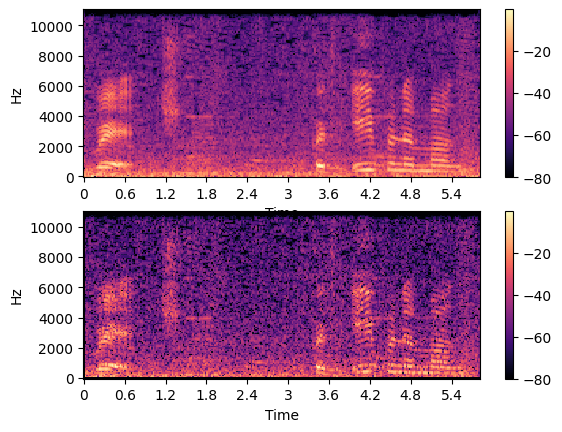

In [20]:
sample_spec_np = sample_spec.squeeze().numpy()
full_spec_np = full_spec.squeeze().numpy()

plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(sample_spec_np, ref=np.max),
                        x_axis = 'time', y_axis='linear')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(full_spec_np, ref=np.max),
                        x_axis = 'time', y_axis='linear')
plt.colorbar()

In [21]:
# Just the encoder training:
# model00conf00: Basic spec and model conf: 10 iterations
# model00conf01: Same model, normalised audio
torch.save(model.state_dict(), 'models/JE_model00_conf01.pt')